In [1]:
import sys
from pathlib import Path
sys.path.insert(0, str(Path.cwd().parent))

import pandas as pd
import numpy as np

from src.data_cleaning import read_data, clean_data

### 1. Data Cleaning & Preprocessing

In [2]:
df = read_data("../../../docs/MSDS_cleaned_0122.xlsx")
df = clean_data(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277 entries, 0 to 276
Data columns (total 99 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            277 non-null    int64  
 1   age                           277 non-null    int64  
 2   sex                           277 non-null    object 
 3   bmi                           250 non-null    float64
 4   Race                          276 non-null    object 
 5   LOS_min                       276 non-null    float64
 6   PROC_TIME_MIN                 276 non-null    float64
 7   SMOKING                       228 non-null    object 
 8   C7CSVL_preop                  274 non-null    float64
 9   SVA_preop                     275 non-null    float64
 10  TK_T4_T12_preop               275 non-null    float64
 11  TK_T10_L2_preop               275 non-null    float64
 12  T4PA_preop                    275 non-null    float64
 13  L1PA_

### 1.1 Define input variables

In [3]:

PREDICTORS = [
    "age", "sex", "bmi",
    "PI_preop", "PT_preop", "LL_preop", "SS_preop",
    "T4PA_preop", "L1PA_preop", "SVA_preop",
    "cobb_main_curve_preop", "FC_preop", "tscore_femneck_preop",
    "HU_UIV_preop", "HU_UIVplus1_preop", "HU_UIVplus2_preop",
    "L4S1_preop"
]

PLAN_COLS = [
    "UIV_implant", "updated_num_levels", "num_fused_levels",
    "ALIF", "XLIF", "TLIF",
    "num_rods", "num_screws", "osteotomy",
]

features = [c for c in (PREDICTORS + PLAN_COLS) if c in df.columns]

cat_features = [c for c in features if df[c].dtype == "object"]
num_features = [c for c in features if df[c].dtype != "object"]



### 2. Build Models

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
#import graphviz

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_predict, KFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor as DTR, plot_tree, export_text, export_graphviz
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, f1_score, PredictionErrorDisplay
from xgboost import XGBRegressor



#### Functions for model building and hyperparemeter tuning

In [5]:
def build_rf_model(df, features, cat_features,num_features, X_train, X_test,y_train,y_test):
    "Builds and fits a Random Forest model using a pipeline"

    num_transformer = Pipeline(
        steps=[("imputer", SimpleImputer(strategy="median"))]
    )

    cat_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),  
            ("encoder", OneHotEncoder(handle_unknown="ignore")) 
        ]
    )

    # Transform heterogeneous data types
    rf_preprocessor = ColumnTransformer(
        transformers=[
            ("num", num_transformer, num_features),
            ("cat", cat_transformer, cat_features),
        ]
    )

    rf_pipeline = Pipeline([
        ("preprocessor", rf_preprocessor), 
        ("regressor", RandomForestRegressor(n_estimators=500, 
                                            random_state=42,
                                            max_depth=8,
                                            min_samples_leaf=5,
                                            oob_score=True))
    ])

    rf_pipeline.fit(X_train, y_train)

    y_pred = rf_pipeline.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    oob = rf_pipeline.named_steps["regressor"].oob_score_

    return rf_pipeline, r2, rmse, oob, y_pred
                   

def randomized_search_cv(pipeline, X_train,y_train, X_test,y_test, param_distributions ):
    "Performs randomized search cross-validation on a model"
    
    random_search = RandomizedSearchCV(
        pipeline,
        param_distributions,
        cv=5,
        scoring="r2",
        n_jobs=-1
    )
    #fit the model
    random_search.fit(X_train,y_train)

    #best paramaters
    best_parameters = random_search.best_params_
    best_cv_R2 = random_search.best_score_
    best_model = random_search.best_estimator_

    #prediction
    y_pred = random_search.predict(X_test)

    #metrics
    test_R2 = r2_score(y_test, y_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred)) 

    return best_parameters, best_cv_R2, best_model, y_pred, test_R2,test_rmse

def build_xgboost_model(df, features, cat_features,num_features, X_train, X_test,y_train,y_test):
    "Builds and fits an XGBoost model using a pipeline"

    num_transformer = Pipeline(
        steps=[("imputer", SimpleImputer(strategy="median"))]
    )

    cat_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),  
            ("encoder", OneHotEncoder(handle_unknown="ignore")) 
        ]
    )

    # Transform heterogeneous data types
    xgb_preprocessor = ColumnTransformer(
        transformers=[
            ("num", num_transformer, num_features),
            ("cat", cat_transformer, cat_features),
        ]
    )

    xgb_pipeline = Pipeline([
        ("preprocessor", xgb_preprocessor),
        ("regressor", XGBRegressor(
            n_estimators=500,
            learning_rate=0.05,
            max_depth=6,
            subsample=0.9,
            colsample_bytree=0.9,
            random_state=42
        ))
        ])

    xgb_pipeline.fit(X_train, y_train)
    y_pred_xgb = xgb_pipeline.predict(X_test)

    r2 = r2_score(y_test, y_pred_xgb)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
  

    return xgb_pipeline, r2, rmse, y_pred_xgb


def build_ridge_model(df, features, cat_features, num_features, X_train, X_test,y_train,y_test, alpha=1):
    "Builds and fits a Ridge Regression model within a pipeline"

    num_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()) 
    ])

    cat_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ])

    ridge_preprocessor = ColumnTransformer(transformers=[
        ("num", num_transformer, num_features),
        ("cat", cat_transformer, cat_features),
    ])

    ridge_pipeline = Pipeline([
        ("preprocessor", ridge_preprocessor),
        ("regressor", Ridge(alpha=alpha))
    ])

    ridge_pipeline.fit(X_train, y_train)
    y_pred_ridge = ridge_pipeline.predict(X_test)

    r2 = r2_score(y_test, y_pred_ridge)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_ridge))

    return ridge_pipeline, r2, rmse, y_pred_ridge       


#### 2.1. Model 1: L4S1 change

In [20]:
#1. Random forest

df["L4S1_change"] = df["L4_S1_postop"] - df["L4S1_preop"]

#drop null values
df = df.dropna(subset=["L4S1_change"])
    
X = df[features]
y = df["L4S1_change"]

#split into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#fit model
L4S1_rf_pipeline, L4S1_r2, L4S1_rmse, L4S1_oob, L4S1_ypred\
      = build_rf_model(df,features, cat_features, num_features, X_train, X_test,y_train,y_test)

print("-- Random Forest Model for L4S1 Change --")

print(f"R² score: {L4S1_r2:.3f}")
print(f"RMSE: {L4S1_rmse:.3f}")
print(f"OOB score: {L4S1_oob:.3f}")

-- Random Forest Model for L4S1 Change --
R² score: 0.251
RMSE: 10.228
OOB score: 0.426


In [22]:
#Randomized search cross-validation to finetune Random Forest parameters
param_distributions = {"regressor__n_estimators": [200, 300, 400, 500, 600],
               "regressor__max_depth": [ 8, 12, 15, 20, None],
               "regressor__min_samples_split" : [2, 5, 10, 15, 20],
               "regressor__min_samples_leaf": [2, 4, 6, 8, 10], 
               "regressor__max_features": ["sqrt", "log2"]}


L4S1_cv_parameters, L4S1_cv_R2, L4S1_tuned_rf, L4S1_cv_ypred, L4S1_cv_testR2, L4S1_cv_rmse  = \
    randomized_search_cv(L4S1_rf_pipeline,X_train,y_train,X_test,y_test, param_distributions)

print("--Randomized search results--")
print(f"Best parameters: {L4S1_cv_parameters}")
print(f"Best CV R2: {L4S1_cv_R2:.3f}")
print(f"Test R2: {L4S1_cv_testR2:.3f}")
print(f"Test RMSE: {L4S1_cv_rmse:.3f}")



--Randomized search results--
Best parameters: {'regressor__n_estimators': 200, 'regressor__min_samples_split': 10, 'regressor__min_samples_leaf': 2, 'regressor__max_features': 'sqrt', 'regressor__max_depth': 12}
Best CV R2: 0.359
Test R2: 0.286
Test RMSE: 9.987


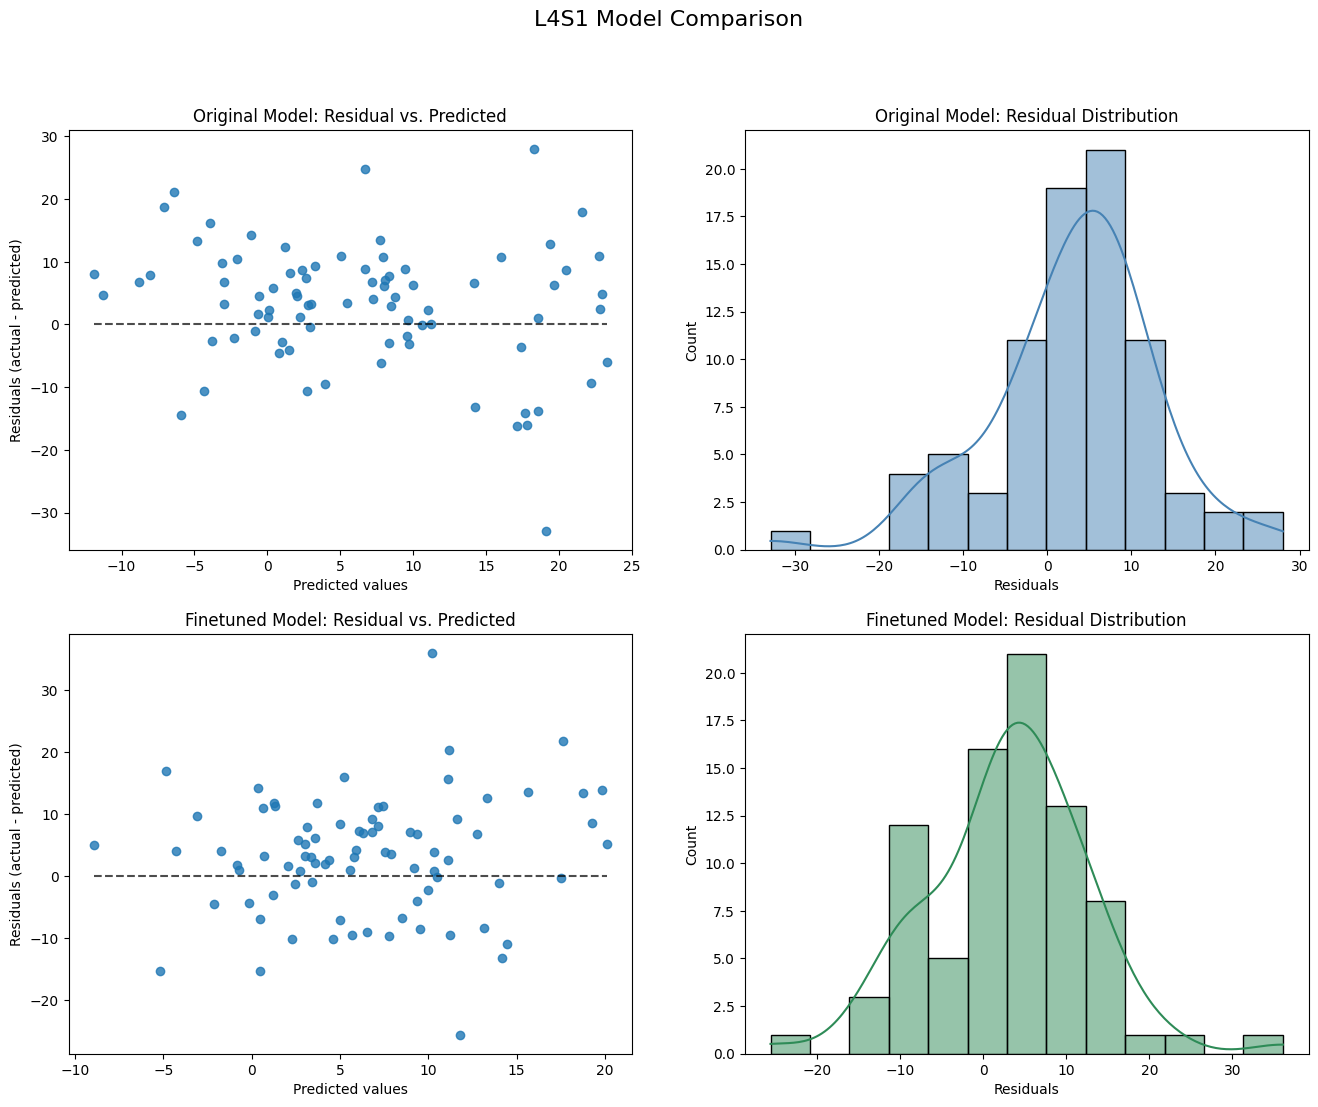

In [23]:
#Visualization of residuals

fig, ax = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle("L4S1 Model Comparison", fontsize=16)

# Plot 1: Residual vs. Predicted (original model)
PredictionErrorDisplay.from_predictions(
    y_true=y_test, y_pred=L4S1_ypred, kind="residual_vs_predicted", 
    ax=ax[0, 0])
ax[0, 0].set_title("Original Model: Residual vs. Predicted")

# Plot 2:  Residual histogram (original model)
L4S1_residuals = y_test - L4S1_ypred
sns.histplot(x=L4S1_residuals, kde=True, ax=ax[0, 1], color='steelblue')
ax[0, 1].set_title("Original Model: Residual Distribution")
ax[0, 1].set_xlabel("Residuals")

# 
# Plot 3: Residual vs. Predicted (finetuned model)
PredictionErrorDisplay.from_predictions(
    y_true=y_test, y_pred=L4S1_cv_ypred, kind="residual_vs_predicted", 
    ax=ax[1, 0]
)
ax[1, 0].set_title("Finetuned Model: Residual vs. Predicted")

# Plot 4: Residual Histogram (finetuned model)
L4S1_cv_residuals = y_test - L4S1_cv_ypred
sns.histplot(x=L4S1_cv_residuals, kde=True, ax=ax[1, 1], color='seagreen')
ax[1, 1].set_title("Finetuned Model: Residual Distribution")
ax[1, 1].set_xlabel("Residuals")

plt.show()

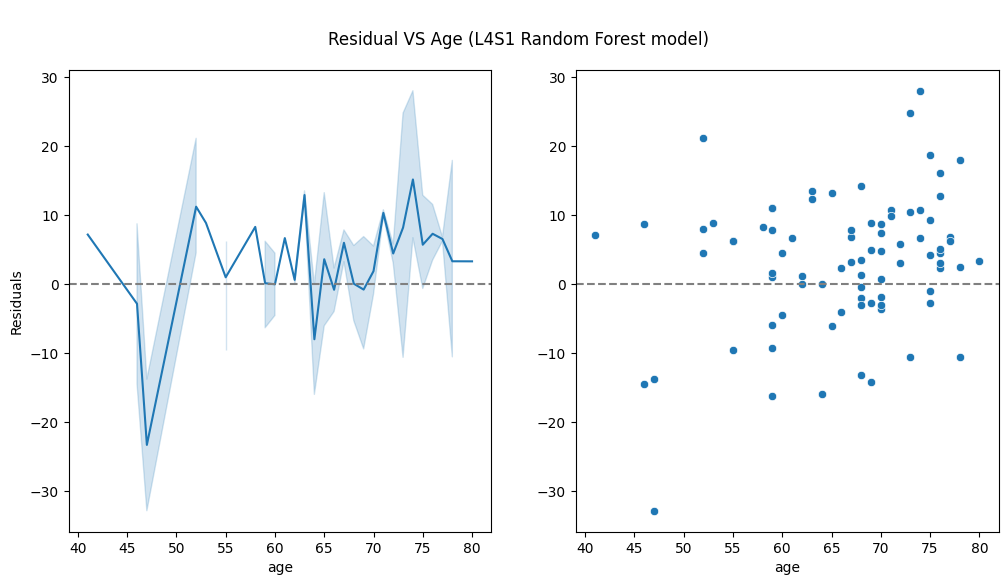

In [68]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
fig.suptitle("\nResidual VS Age (L4S1 Random Forest model)")
#fig.supylabel("residuals")

L4S1_residuals = y_test - L4S1_ypred

sns.lineplot(x=X_test["age"], y=L4S1_residuals, ax=ax[0])
sns.scatterplot(x=X_test["age"], y=L4S1_residuals, ax=ax[1])

ax[0].axhline(y=0,linestyle="--",color="grey")
ax[0].set_ylabel("Residuals")
ax[1].set_ylabel("")
ax[1].axhline(y=0,linestyle="--",color="grey")

plt.show()




In [ ]:
#feature importance
importances = L4S1_tuned_rf.named_steps["regressor"].feature_importances_

#get transformed categorical feature names
hotcoded_names = list(L4S1_tuned_rf.named_steps["preprocessor"].transformers_[1][1].get_feature_names_out(cat_features))

feature_names = num_features + hotcoded_names

forest_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)

print("Feature Importance")
print(forest_importances)

Feature Importance
L4S1_preop                   0.240465
T4PA_preop                   0.097276
L1PA_preop                   0.090114
LL_preop                     0.071257
SVA_preop                    0.063772
PT_preop                     0.051017
SS_preop                     0.042032
ALIF                         0.038620
FC_preop                     0.036697
HU_UIVplus2_preop            0.034224
PI_preop                     0.030492
tscore_femneck_preop         0.030327
cobb_main_curve_preop        0.028293
bmi                          0.027514
HU_UIV_preop                 0.025260
HU_UIVplus1_preop            0.022048
age                          0.020807
osteotomy                    0.015351
num_rods                     0.014558
updated_num_levels_higher    0.003181
UIV_implant_Hook             0.002940
UIV_implant_PS               0.002936
sex_FEMALE                   0.002805
updated_num_levels_lower     0.002755
sex_MALE                     0.002109
XLIF                         0.

In [ ]:
#2. xgboost 

#fit model
L4S1_xgb_pipeline, L4S1_xgb_r2, L4S1_xgb_rmse, L4S1_xgb_ypred\
      = build_xgboost_model(df,features, cat_features, num_features,X_train, X_test,y_train,y_test)

print("-- XGBoost Model for L4S1 change --")

print(f"R² score: {L4S1_xgb_r2:.3f}")
print(f"RMSE: {L4S1_xgb_rmse:.3f}")


-- XGBoost Model for L4S1 change --
R² score: 0.212
RMSE: 10.495


In [ ]:
#3 ridge regression - might be good for overfitting and correlated features
L4S1_ridge_pipeline, L4S1_ridge_r2, L4S1_ridge_rmse, L4S1_ridge_ypred\
      = build_ridge_model(df,features, cat_features, num_features, X_train, X_test,y_train,y_test)

print("-- Ridge Model for L4S1 change --")

print(f"R² score: {L4S1_ridge_r2:.3f}")
print(f"RMSE: {L4S1_ridge_rmse:.3f}")

-- Ridge Model for L4S1 change --
R² score: 0.404
RMSE: 9.125


In [ ]:
#Randomized search cross-validation to finetune Ridge regression parameters

ridge_param_distributions = {"regressor__alpha": [1, 2, 3, 5, 10, 15]}

L4S1_ridge_parameters, L4S1_ridge_cv_R2, L4S1_tuned_ridge, L4S1_tuned_ypred, L4S1_ridge_testR2, L4S1_ridge_rmse  = \
    randomized_search_cv(L4S1_ridge_pipeline,X_train,y_train,X_test,y_test, ridge_param_distributions )

print("--Randomized search results--")
print(f"Best parameters: {L4S1_ridge_parameters}")
print(f"Best CV R2: {L4S1_ridge_cv_R2:.3f}")
print(f"Test R2: {L4S1_ridge_testR2:.3f}")
print(f"Test RMSE: {L4S1_ridge_rmse:.3f}")


/Users/jennkim/Library/Caches/pypoetry/virtualenvs/capstone-hbAn-vE8-py3.12/lib/python3.12/site-packages/sklearn/model_selection/_search.py:324: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


--Randomized search results--
Best parameters: {'regressor__alpha': 15}
Best CV R2: 0.492
Test R2: 0.389
Test RMSE: 9.236


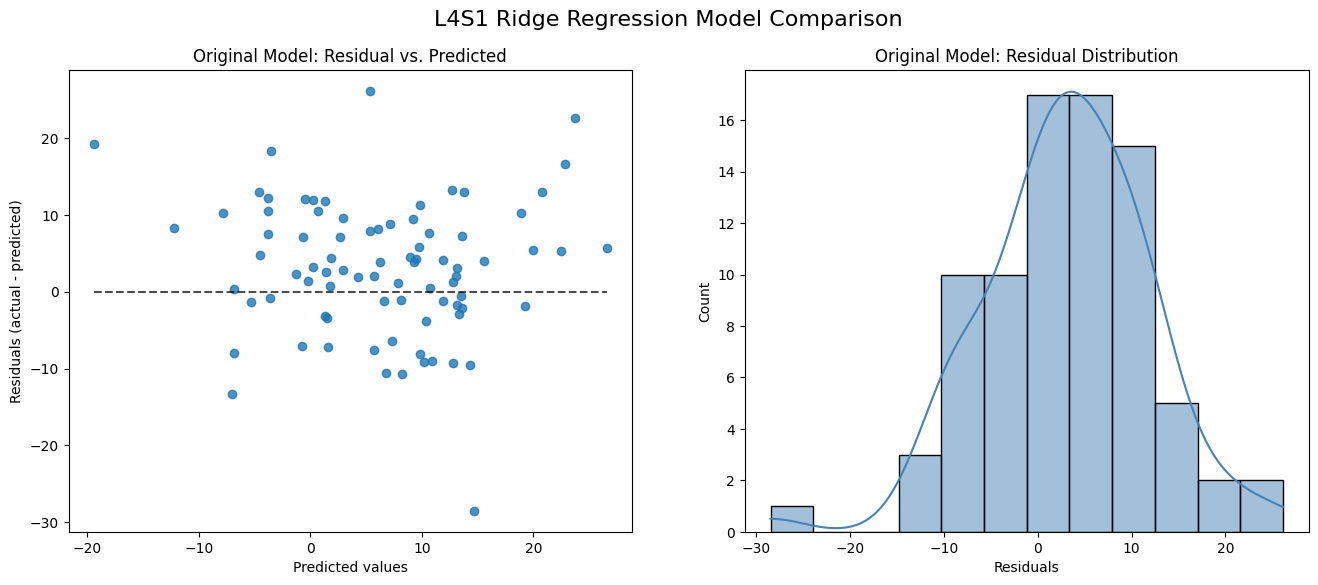

In [ ]:
#Visualization of residuals

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle("L4S1 Ridge Regression Model Comparison", fontsize=16)

# Plot 1: Residual vs. Predicted (original model)
PredictionErrorDisplay.from_predictions(
    y_true=y_test, y_pred=L4S1_ridge_ypred, kind="residual_vs_predicted", 
    ax=ax[0])
ax[0].set_title("Original Model: Residual vs. Predicted")

# Plot 2:  Residual histogram (original model)
L4S1_ridge_residuals = y_test - L4S1_ridge_ypred
sns.histplot(x=L4S1_ridge_residuals, kde=True, ax=ax[1], color='steelblue')
ax[1].set_title("Original Model: Residual Distribution")
ax[1].set_xlabel("Residuals")


plt.show()

### 2.2 Model 2: LL Change

In [10]:
#1. Random forest

df["LL_change"] = df["LL_postop"] - df["LL_preop"]

df = df.dropna(subset=["LL_change"])
    
X = df[features]
y = df["LL_change"]

#split into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#fit model
LL_rf_pipeline, LL_rf_r2, LL_rf_rmse, LL_rf_oob, LL_ypred\
      = build_rf_model(df,features, cat_features, num_features, X_train, X_test,y_train,y_test)

print("-- Random Forest Model for LL change--")

print(f"R² score: {LL_rf_r2:.3f}")
print(f"RMSE: {LL_rf_rmse:.3f}")
print(f"OOB score: {LL_rf_oob:.3f}")

-- Random Forest Model for LL change--
R² score: 0.542
RMSE: 9.624
OOB score: 0.547


In [ ]:
param_distributions = {"regressor__n_estimators": [200, 300, 400, 500, 600],
               "regressor__max_depth": [ 8, 12, 15, 20, None],
               "regressor__min_samples_split" : [2, 5, 10, 15, 20],
               "regressor__min_samples_leaf": [2, 4, 6, 8, 10], 
               "regressor__max_features": ["sqrt", "log2"]}

LL_cv_params, LL_cv_r2, LL_tuned_rf, LL_cv_ypred, LL_cv_testr2, LL_cv_rmse = \
    randomized_search_cv(LL_rf_pipeline, X_train, y_train, X_test, y_test, param_distributions)

print("--Randomized search results--")
print(f"Best parameters: {LL_cv_params}")
print(f"Best CV R2: {LL_cv_r2:.3f}")
print(f"Test R2: {LL_cv_testr2:.3f}")
print(f"Test RMSE: {LL_cv_rmse:.3f}")

--Randomized search results--
Best parameters: {'regressor__n_estimators': 400, 'regressor__min_samples_split': 2, 'regressor__min_samples_leaf': 4, 'regressor__max_features': 'sqrt', 'regressor__max_depth': None}
Best CV R2: 0.440
Test R2: 0.518
Test RMSE: 9.874


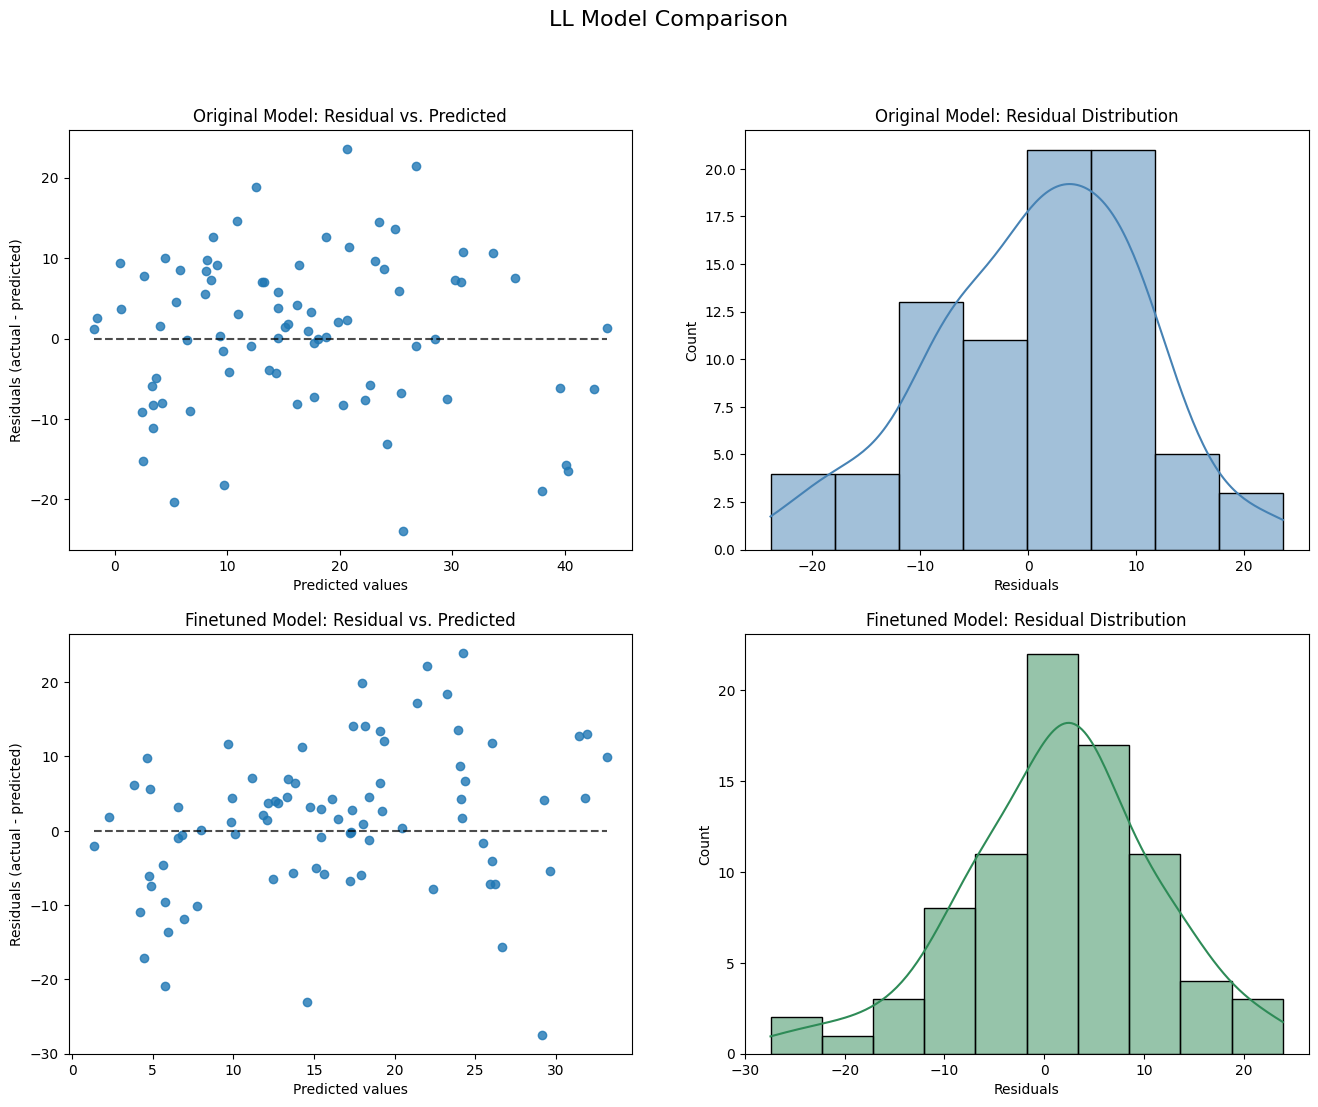

In [ ]:
#Visualization of residuals

fig, ax = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle("LL Model Comparison", fontsize=16)

# Plot 1: Residual vs. Predicted (original model)
PredictionErrorDisplay.from_predictions(
    y_true=y_test, y_pred=LL_ypred, kind="residual_vs_predicted", 
    ax=ax[0, 0])
ax[0, 0].set_title("Original Model: Residual vs. Predicted")

# Plot 2:  Residual histogram (original model)
LL_residuals = y_test - LL_ypred
sns.histplot(x=LL_residuals, kde=True, ax=ax[0, 1], color='steelblue')
ax[0, 1].set_title("Original Model: Residual Distribution")
ax[0, 1].set_xlabel("Residuals")

# Plot 3: Residual vs. Predicted (finetuned model)
PredictionErrorDisplay.from_predictions(
    y_true=y_test, y_pred=LL_cv_ypred, kind="residual_vs_predicted", 
    ax=ax[1, 0]
)
ax[1, 0].set_title("Finetuned Model: Residual vs. Predicted")

# Plot 4: Residual Histogram (finetuned model)
LL_cv_residuals = y_test - LL_cv_ypred
sns.histplot(x=LL_cv_residuals, kde=True, ax=ax[1, 1], color='seagreen')
ax[1, 1].set_title("Finetuned Model: Residual Distribution")
ax[1, 1].set_xlabel("Residuals")

plt.show()

In [201]:
#2. xgboost 

LL_xgb_pipeline, LL_xgb_r2, LL_xgb_rmse, LL_xgb_ypred\
      = build_xgboost_model(df,features, cat_features, num_features,X_train, X_test,y_train,y_test)

print("-- XGBoost Model for LL change--")

print(f"R² score: {LL_xgb_r2:.3f}")
print(f"RMSE: {LL_xgb_rmse:.3f}")

-- XGBoost Model for LL change--
R² score: 0.484
RMSE: 10.214


In [202]:
#3 ridge regression - might be good for overfitting and correlated features
LL_ridge_pipeline, LL_ridge_r2, LL_ridge_rmse, LL_ridge_ypred\
      = build_ridge_model(df,features, cat_features, num_features, X_train, X_test,y_train,y_test)

print("-- Ridge Model for LL change --")

print(f"R² score: {LL_ridge_r2:.3f}")
print(f"RMSE: {LL_ridge_rmse:.3f}")

-- Ridge Model for LL change --
R² score: 0.592
RMSE: 9.087


In [231]:
#Randomized search cross-validation to finetune Ridge regression parameters

ridge_param_distributions = {"regressor__alpha": [1, 2, 3, 5, 10, 15]}

ll_ridge_parameters, ll_ridge_cv_R2, ll_tuned_ridge, ll_tuned_ypred, ll_ridge_testR2, ll_ridge_rmse  = \
    randomized_search_cv(LL_ridge_pipeline,X_train,y_train,X_test,y_test, ridge_param_distributions )

print("--Randomized search results--")
print(f"Best parameters: {ll_ridge_parameters}")
print(f"Best CV R2: {ll_ridge_cv_R2:.3f}")
print(f"Test R2: {ll_ridge_testR2:.3f}")
print(f"Test RMSE: {ll_ridge_rmse:.3f}")

/Users/jennkim/Library/Caches/pypoetry/virtualenvs/capstone-hbAn-vE8-py3.12/lib/python3.12/site-packages/sklearn/model_selection/_search.py:324: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


--Randomized search results--
Best parameters: {'regressor__alpha': 15}
Best CV R2: 0.485
Test R2: 0.322
Test RMSE: 4.234


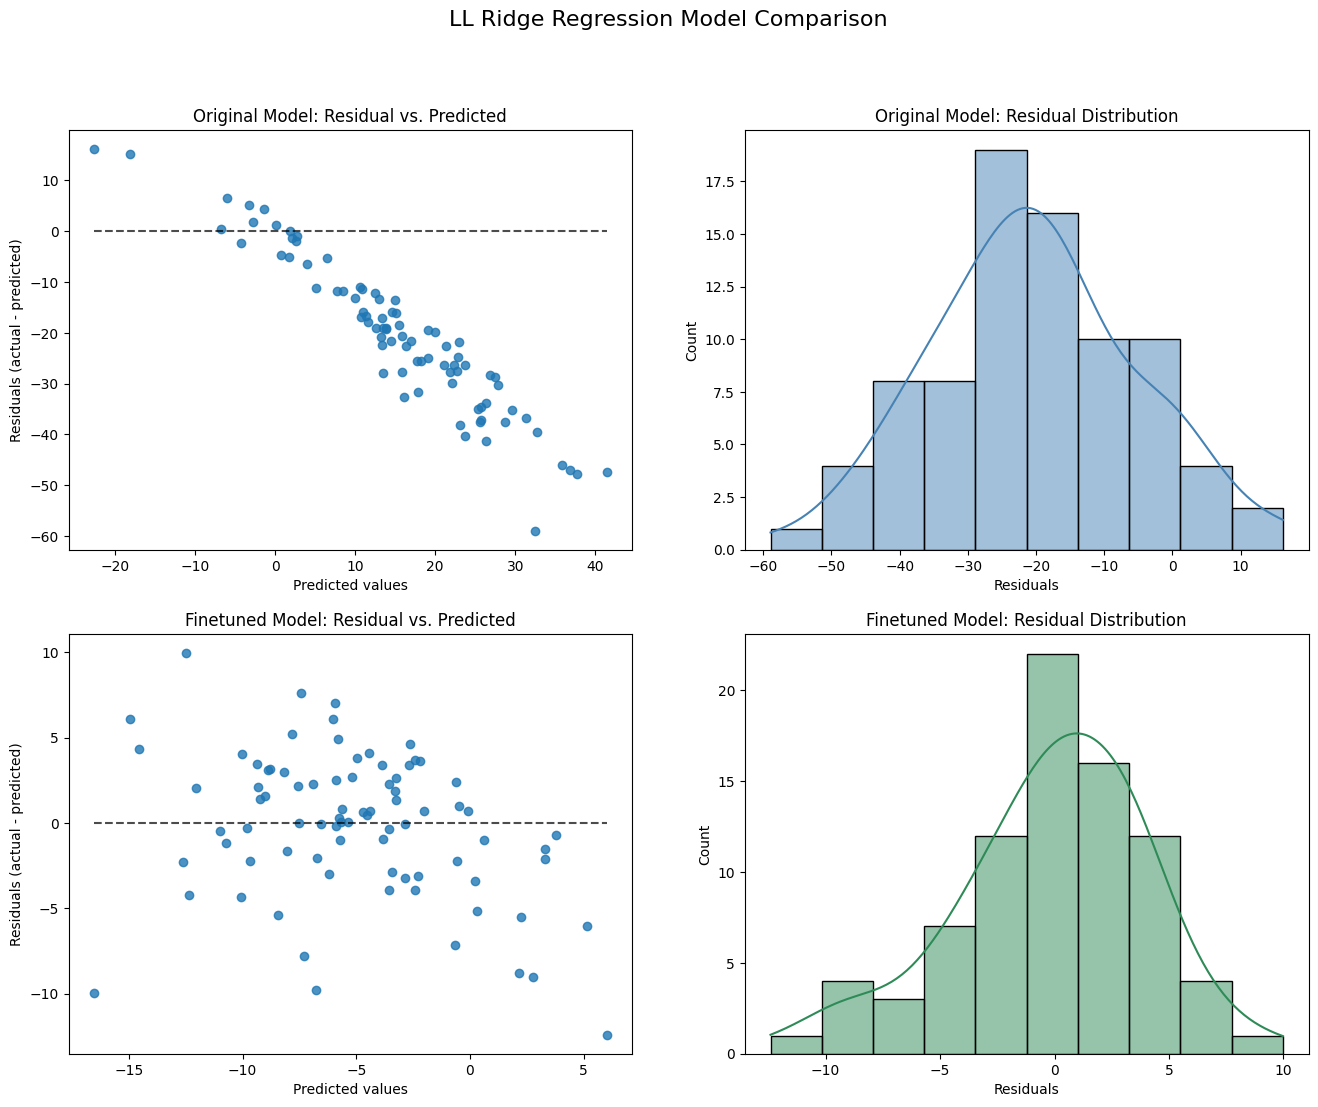

In [232]:
#Visualization of residuals

fig, ax = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle("LL Ridge Regression Model Comparison", fontsize=16)

# Plot 1: Residual vs. Predicted (original model)
PredictionErrorDisplay.from_predictions(
    y_true=y_test, y_pred=LL_ridge_ypred, kind="residual_vs_predicted", 
    ax=ax[0,0])
ax[0,0].set_title("Original Model: Residual vs. Predicted")

# Plot 2:  Residual histogram (original model)
ll_ridge_residuals = y_test - LL_ridge_ypred
sns.histplot(x=ll_ridge_residuals, kde=True, ax=ax[0,1], color='steelblue')
ax[0, 1].set_title("Original Model: Residual Distribution")
ax[0, 1].set_xlabel("Residuals")

# Plot 3: Residual vs. Predicted (finetuned model)
PredictionErrorDisplay.from_predictions(
    y_true=y_test, y_pred=ll_tuned_ypred, kind="residual_vs_predicted", 
    ax=ax[1, 0]
)
ax[1, 0].set_title("Finetuned Model: Residual vs. Predicted")

# Plot 4: Residual Histogram (finetuned model)
LL_ridge_cv_residuals = y_test - ll_tuned_ypred
sns.histplot(x=LL_ridge_cv_residuals, kde=True, ax=ax[1, 1], color='seagreen')
ax[1, 1].set_title("Finetuned Model: Residual Distribution")
ax[1, 1].set_xlabel("Residuals")


plt.show()

### 2.3 Model 3:T4PA Change

In [15]:
#1. Random forest

df["T4PA_change"] = df["T4PA_postop"] - df["T4PA_preop"]

df = df.dropna(subset=["T4PA_change"])
    
X = df[features]
y = df["T4PA_change"]

#split into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#fit model
T4PA_rf_pipeline, T4PA_rf_r2, T4PA_rf_rmse, T4PA_rf_oob, T4PA_ypred\
      = build_rf_model(df,features, cat_features, num_features, X_train, X_test, y_train, y_test)

print("-- Random Forest Model for T4PA change --")

print(f"R² score: {T4PA_rf_r2:.3f}")
print(f"RMSE: {T4PA_rf_rmse:.3f}")
print(f"OOB score: {T4PA_rf_oob:.3f}")

-- Random Forest Model for T4PA change --
R² score: 0.401
RMSE: 6.956
OOB score: 0.643


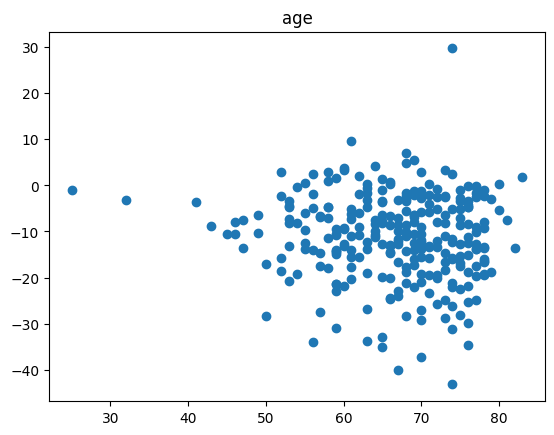

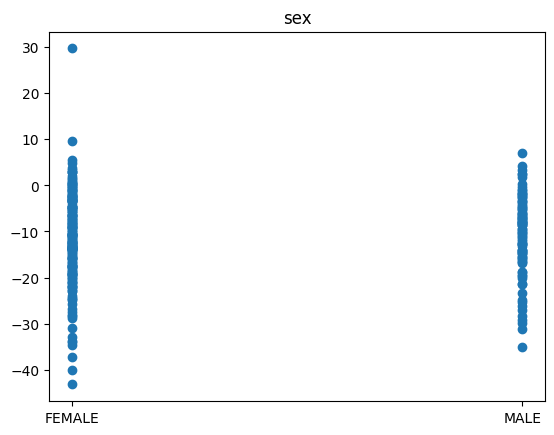

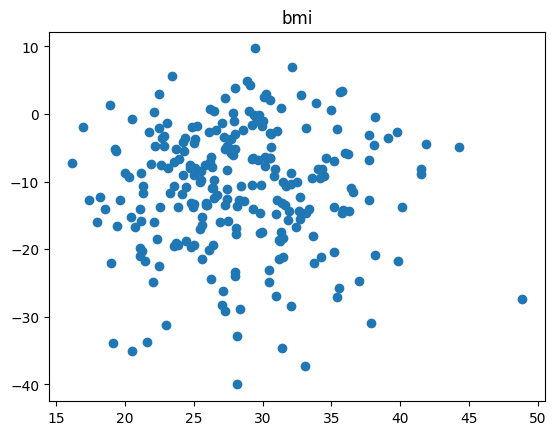

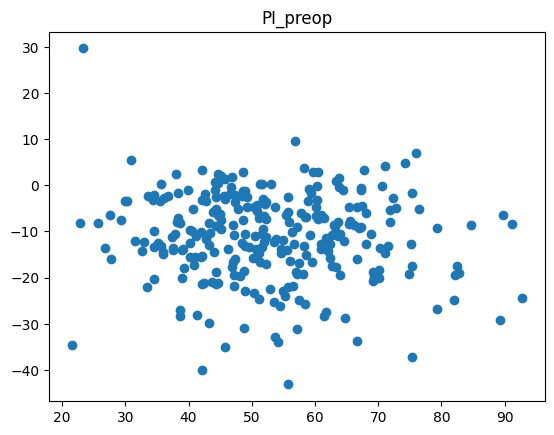

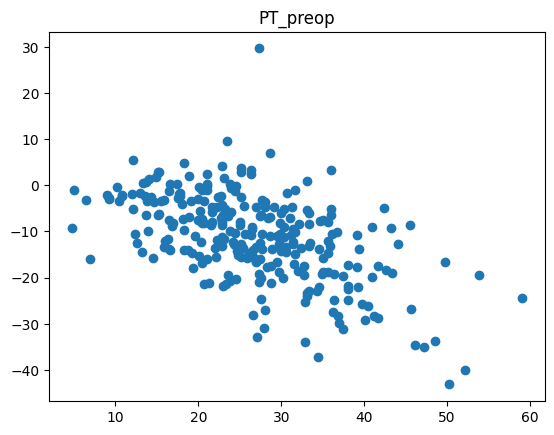

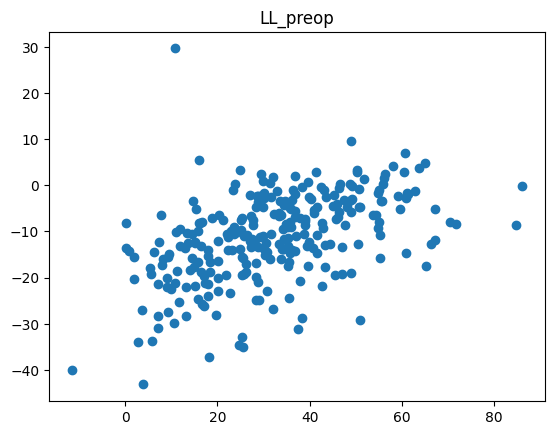

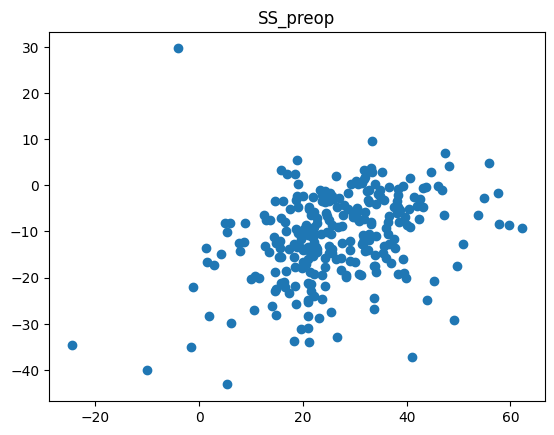

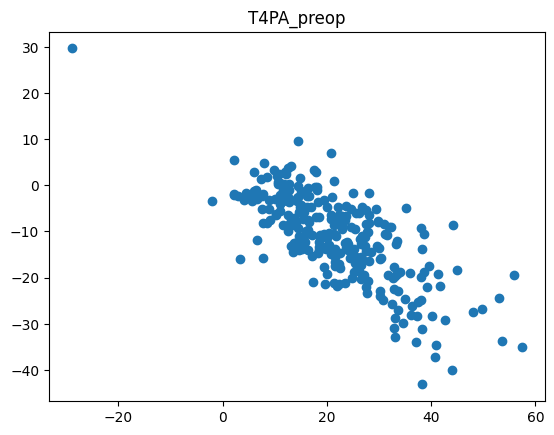

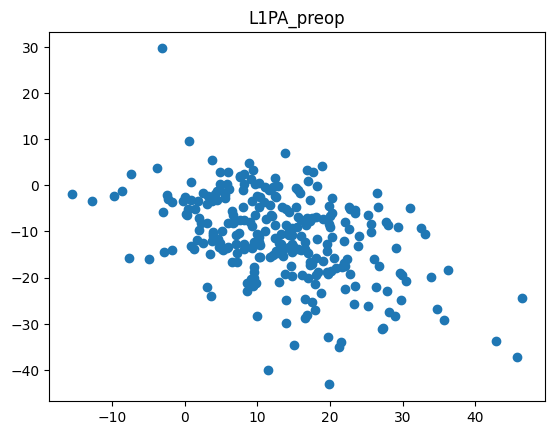

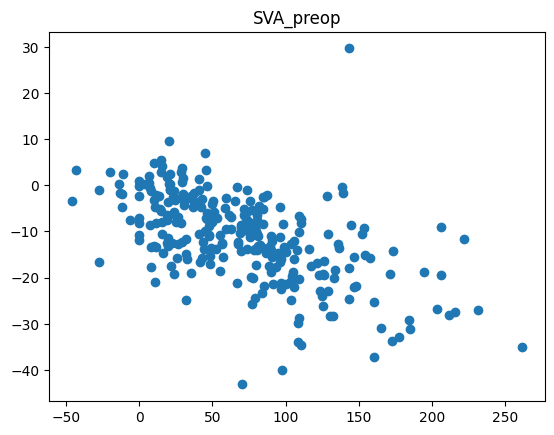

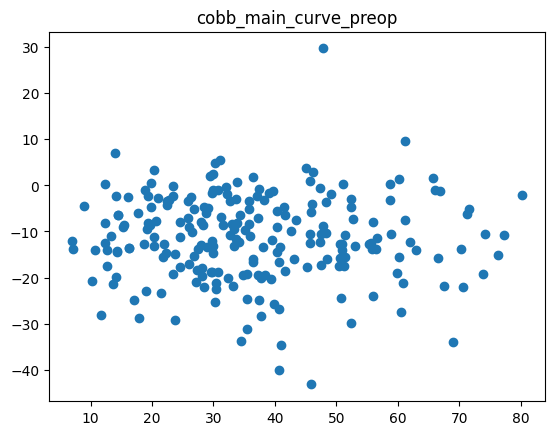

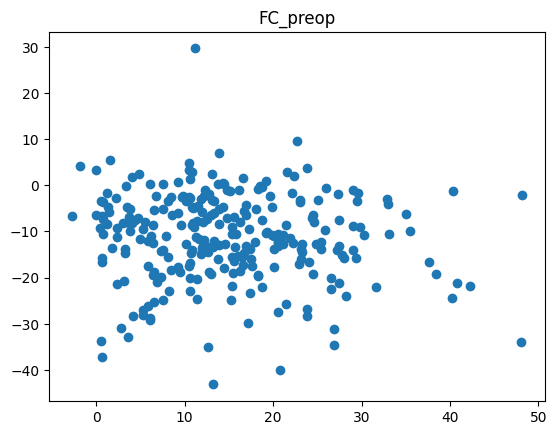

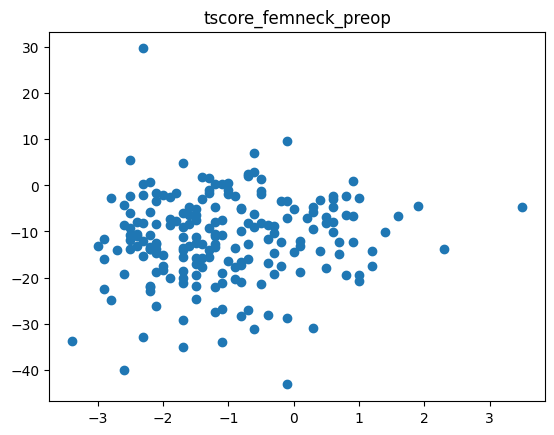

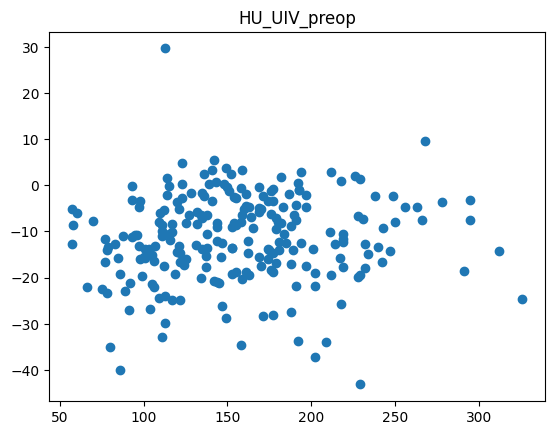

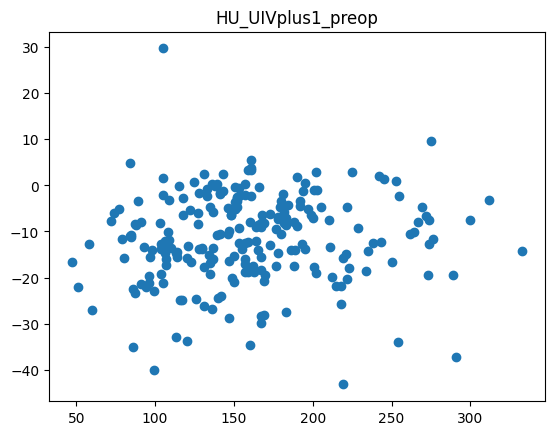

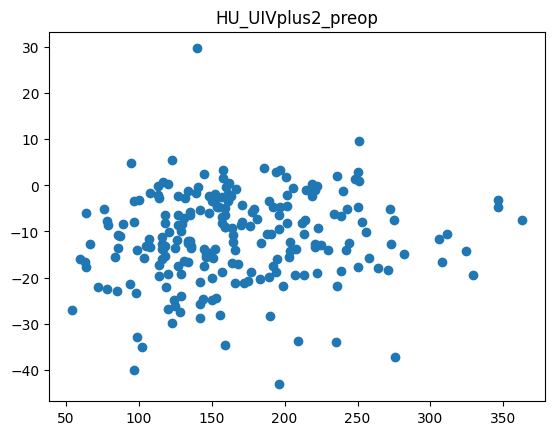

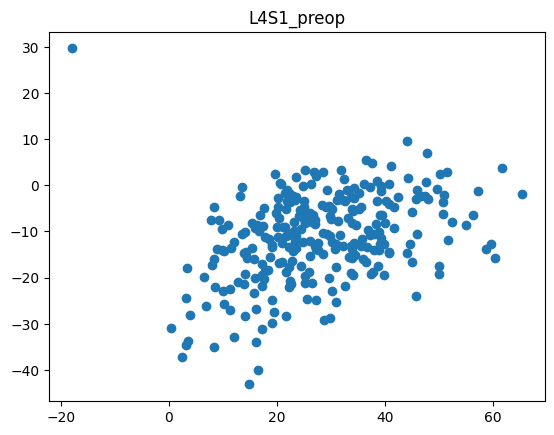

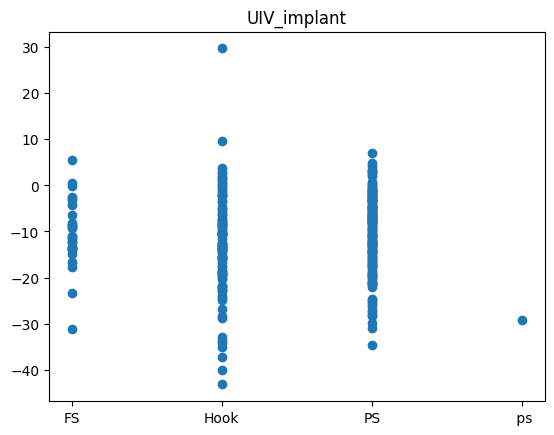

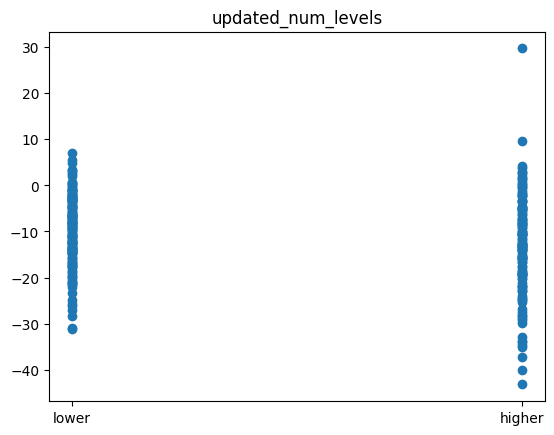

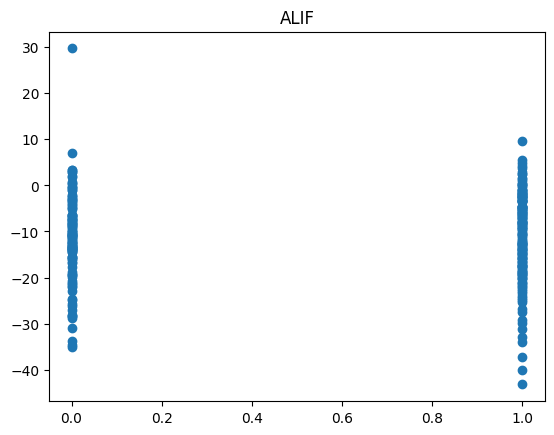

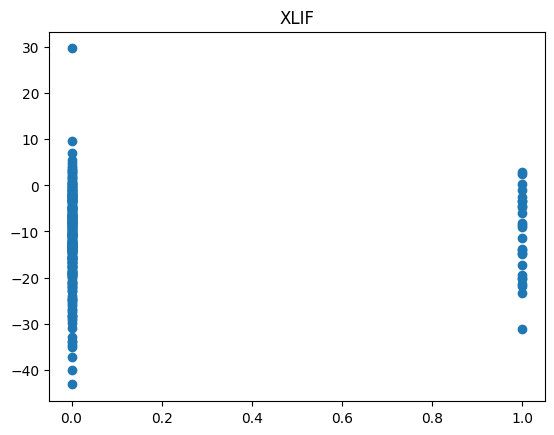

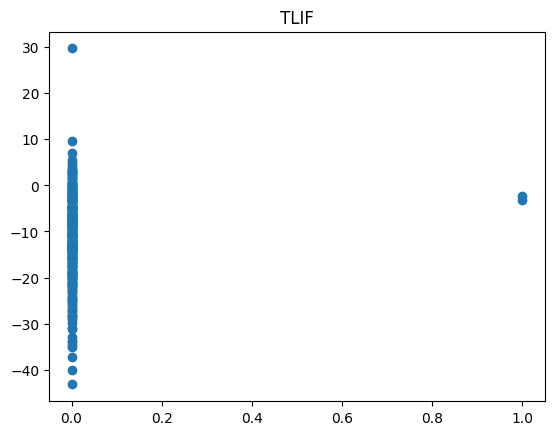

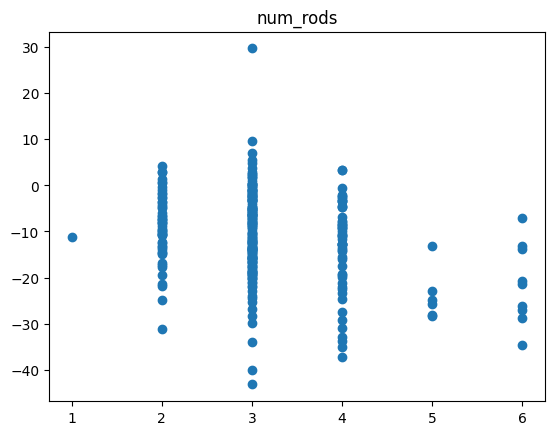

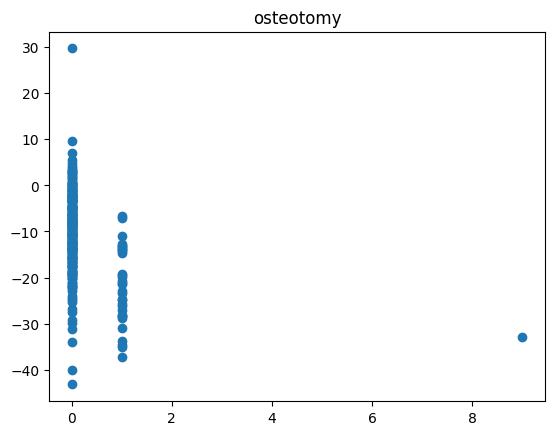

In [16]:
for i in features:
    plt.scatter(df[i], df["T4PA_change"])
    plt.title(i)
    plt.show()

In [209]:
param_distributions = {"regressor__n_estimators": [200, 300, 400, 500, 600],
               "regressor__max_depth": [ 8, 12, 15, 20, None],
               "regressor__min_samples_split" : [2, 5, 10, 15, 20],
               "regressor__min_samples_leaf": [2, 4, 6, 8, 10], 
               "regressor__max_features": ["sqrt", "log2"]}

T4PA_cv_params, T4PA_cv_r2, T4PA_tuned_rf, T4PA_cv_ypred, T4PA_cv_testr2, T4PA_cv_rmse = \
    randomized_search_cv(T4PA_rf_pipeline, X_train, y_train, X_test, y_test, param_distributions)

print("--Randomized search results--")
print(f"Best parameters: {T4PA_cv_params}")
print(f"Best CV R2: {T4PA_cv_r2:.3f}")
print(f"Test R2: {T4PA_cv_testr2:.3f}")
print(f"Test RMSE: {T4PA_cv_rmse:.3f}")

--Randomized search results--
Best parameters: {'regressor__n_estimators': 200, 'regressor__min_samples_split': 2, 'regressor__min_samples_leaf': 2, 'regressor__max_features': 'log2', 'regressor__max_depth': None}
Best CV R2: 0.608
Test R2: 0.298
Test RMSE: 7.531


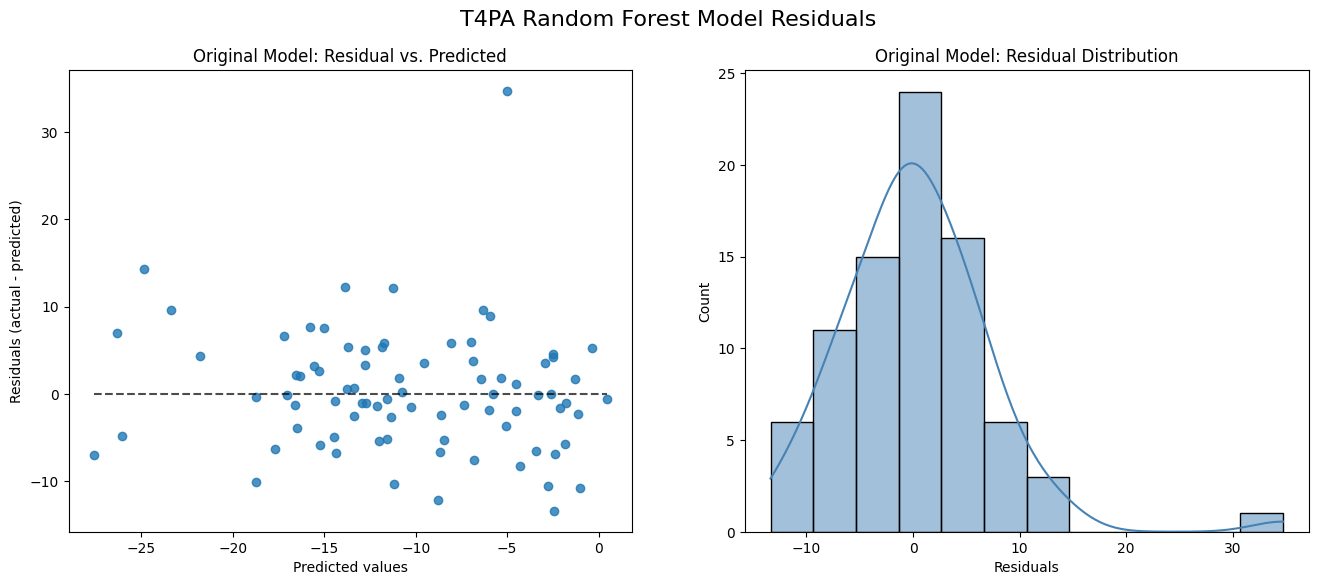

In [ ]:
#Visualization of residuals

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle("T4PA Random Forest Model Residuals", fontsize=16)

# Plot 1: Residual vs. Predicted (original model)
PredictionErrorDisplay.from_predictions(
    y_true=y_test, y_pred=T4PA_ypred, kind="residual_vs_predicted", 
    ax=ax[0])
ax[0].set_title("Original Model: Residual vs. Predicted")

# Plot 2:  Residual histogram (original model)
T4PA_rf_residuals = y_test - T4PA_ypred
sns.histplot(x=T4PA_rf_residuals, kde=True, ax=ax[1], color='steelblue')
ax[1].set_title("Original Model: Residual Distribution")
ax[1].set_xlabel("Residuals")

plt.show()

In [211]:
#2. xgboost 

T4PA_xgb_pipeline, T4PA_xgb_r2, T4PA_xgb_rmse, T4PA_xgb_ypred\
      = build_xgboost_model(df,features, cat_features, num_features, X_train, X_test, y_train, y_test)

print("-- XGBoost Model for T4PA Change --")

print(f"R² score: {T4PA_xgb_r2:.3f}")
print(f"RMSE: {T4PA_xgb_rmse:.3f}")

-- XGBoost Model for T4PA Change --
R² score: 0.348
RMSE: 7.262


In [ ]:
#3 ridge regression - might be good for overfitting and correlated features

T4PA_ridge_pipeline, T4PA_ridge_r2, T4PA_ridge_rmse, T4PA_ridge_ypred\
      = build_ridge_model(df,features, cat_features, num_features,X_train, X_test, y_train, y_test)

print("-- Ridge Model for T4PA Change --")

print(f"R² score: {T4PA_ridge_r2:.3f}")
print(f"RMSE: {T4PA_ridge_rmse:.3f}")

-- Ridge Model for T4PA Change --
R² score: 0.574
RMSE: 5.866


In [213]:
#Randomized search cross-validation to finetune Ridge regression parameters

ridge_param_distributions = {"regressor__alpha": [1, 2, 3, 5, 10, 15]}

T4PA_ridge_parameters, T4PA_ridge_cv_R2, T4PA_tuned_ridge, T4PA_tuned_ypred, T4PA_ridge_testR2, T4PA_ridge_rmse  = \
    randomized_search_cv(T4PA_ridge_pipeline,X_train,y_train,X_test,y_test, ridge_param_distributions)

print("--Randomized search results--")
print(f"Best parameters: {T4PA_ridge_parameters}")
print(f"Best CV R2: {T4PA_ridge_cv_R2:.3f}")
print(f"Test R2: {T4PA_ridge_testR2:.3f}")
print(f"Test RMSE: {T4PA_ridge_rmse:.3f}")

/Users/jennkim/Library/Caches/pypoetry/virtualenvs/capstone-hbAn-vE8-py3.12/lib/python3.12/site-packages/sklearn/model_selection/_search.py:324: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


--Randomized search results--
Best parameters: {'regressor__alpha': 15}
Best CV R2: 0.596
Test R2: 0.465
Test RMSE: 6.579


### 2.4 Model 4:L1PA Change

In [17]:
#1. Random forest

df["L1PA_change"] = df["L1PA_postop"] - df["L1PA_preop"]

df = df.dropna(subset=["L1PA_change"])
    
X = df[features]
y = df["L1PA_change"]

#split into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#fit model
L1PA_rf_pipeline, L1PA_rf_r2, L1PA_rf_rmse, L1PA_rf_oob, L1PA_ypred\
      = build_rf_model(df,features, cat_features, num_features,X_train, X_test, y_train, y_test)

print("-- Random Forest Model for L1PA Change --")

print(f"R² score: {L1PA_rf_r2:.3f}")
print(f"RMSE: {L1PA_rf_rmse:.3f}")
print(f"OOB score: {L1PA_rf_oob:.3f}")

-- Random Forest Model for L1PA Change --
R² score: 0.304
RMSE: 4.292
OOB score: 0.491


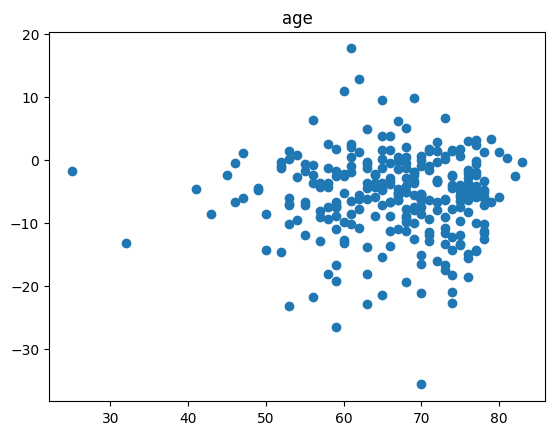

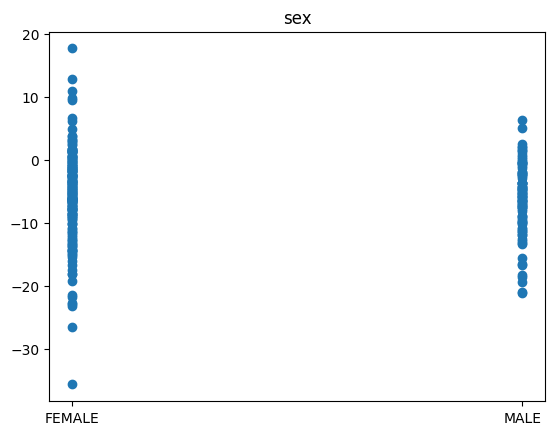

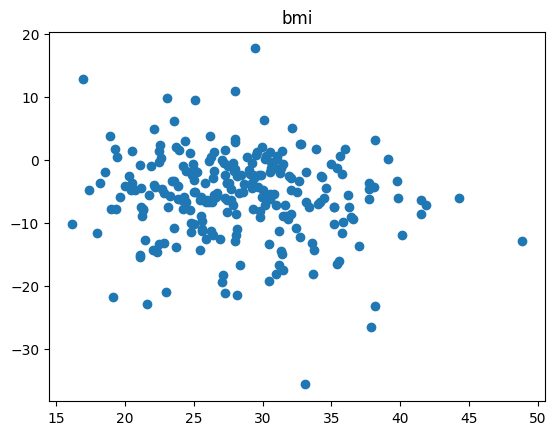

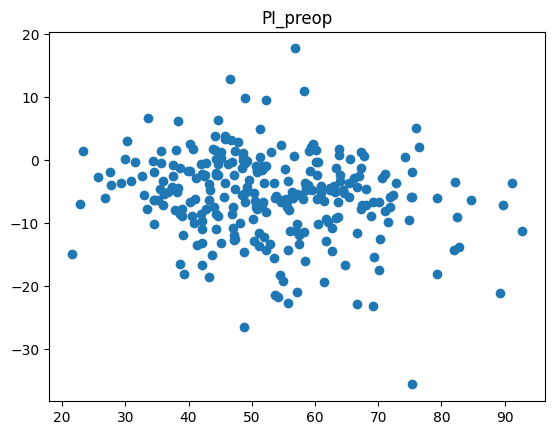

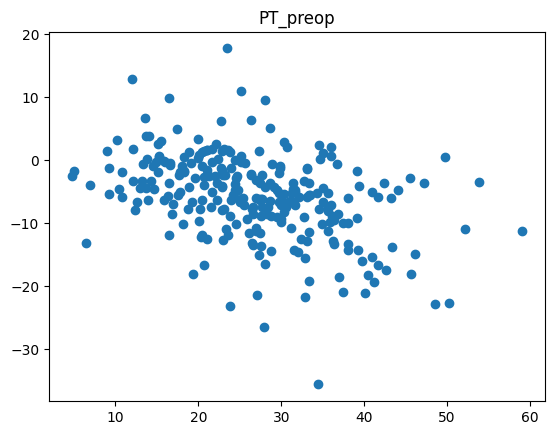

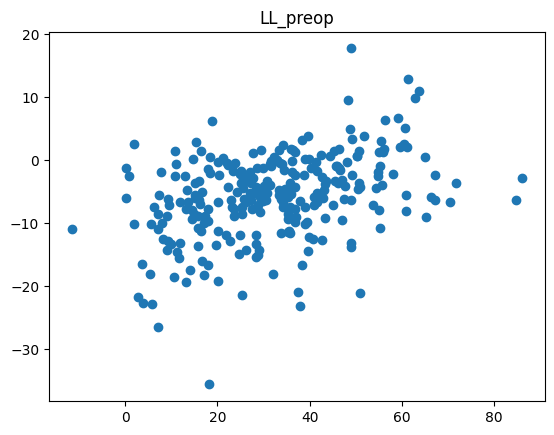

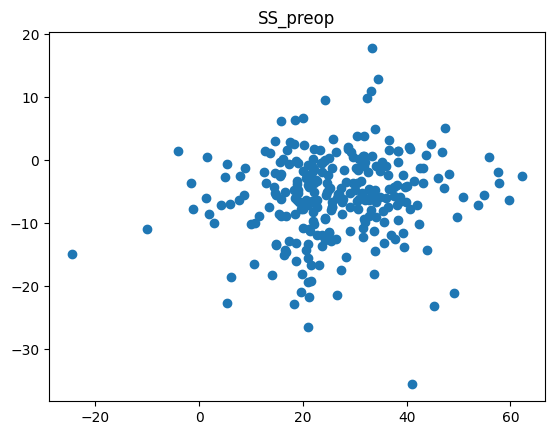

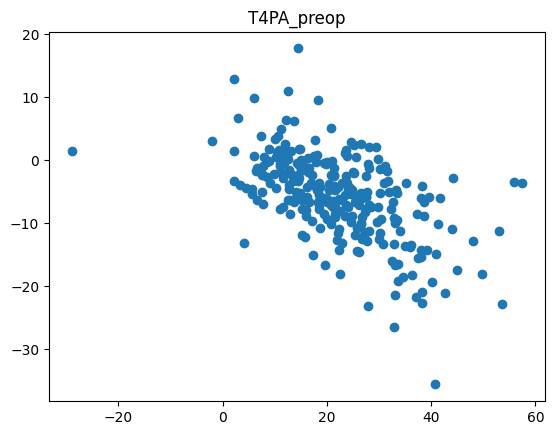

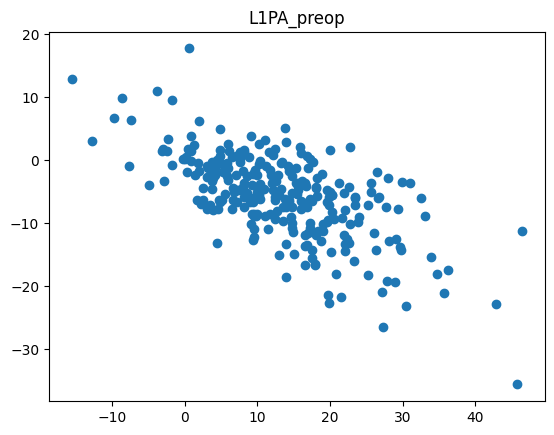

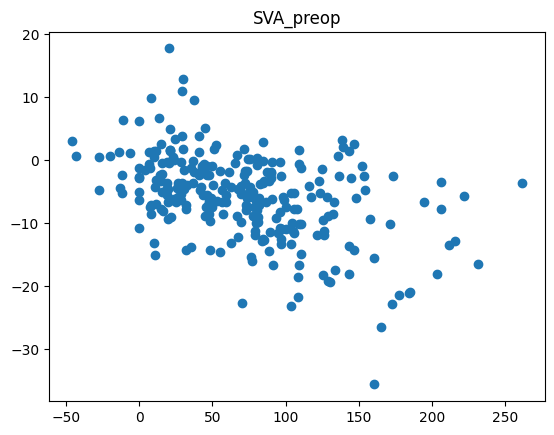

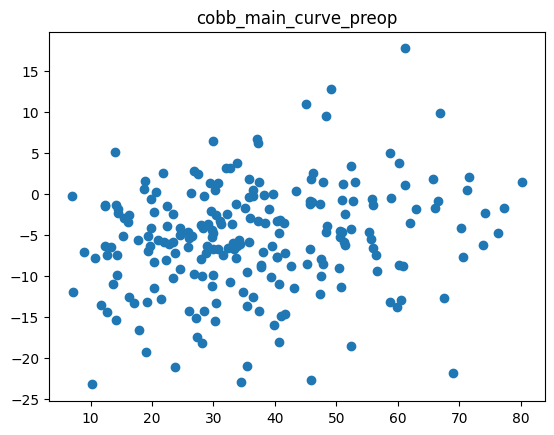

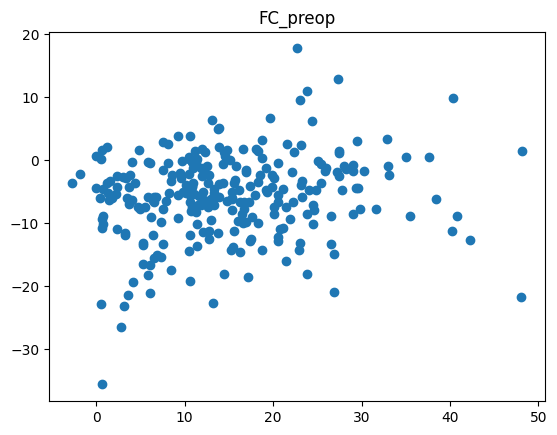

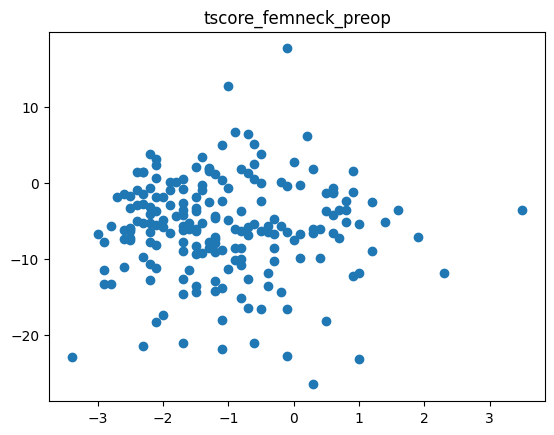

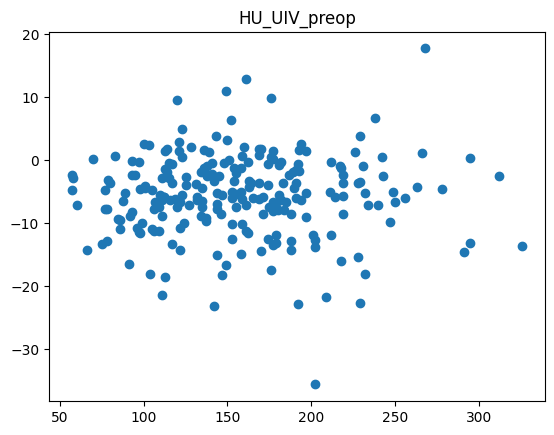

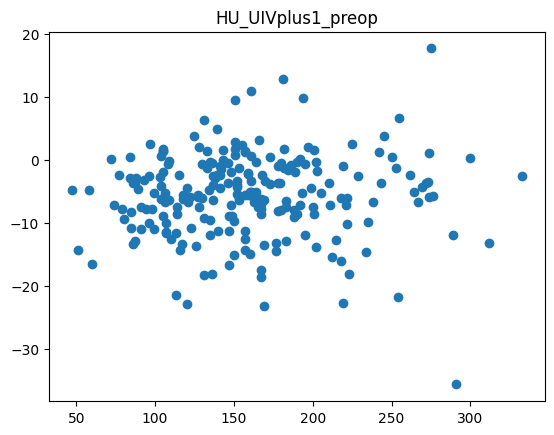

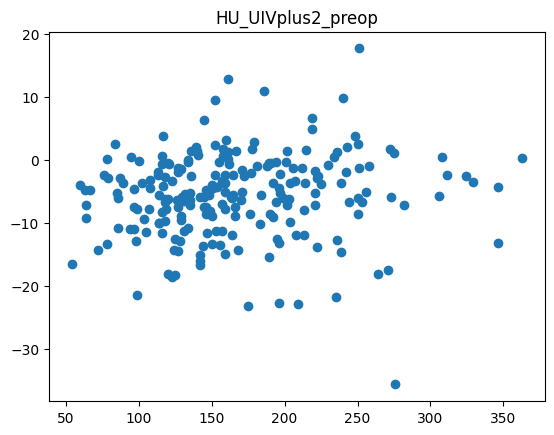

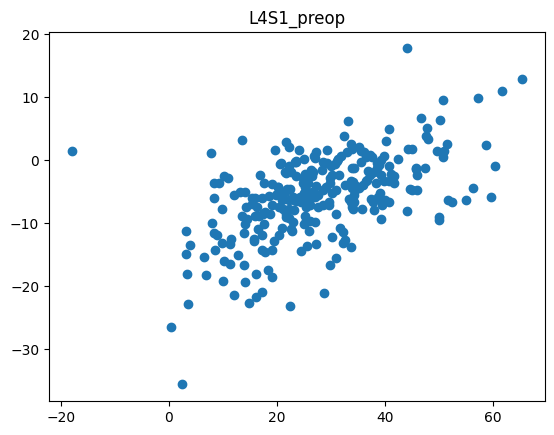

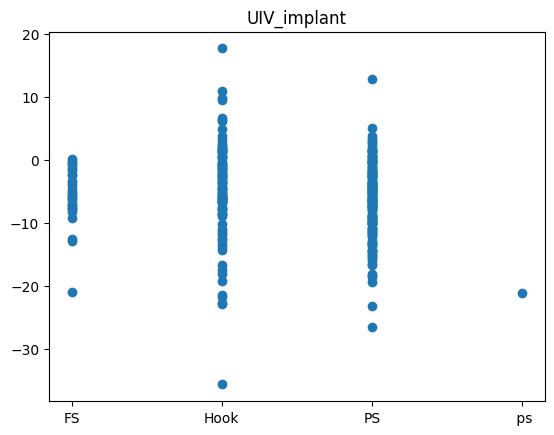

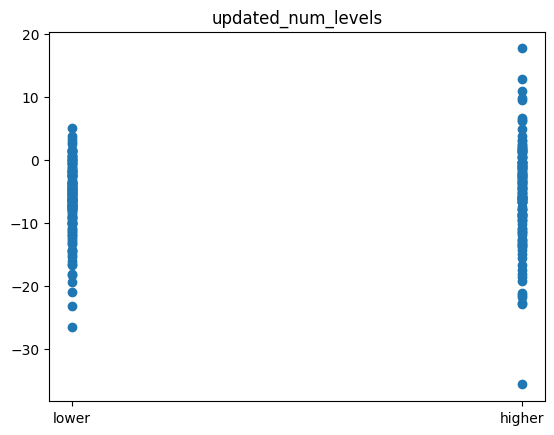

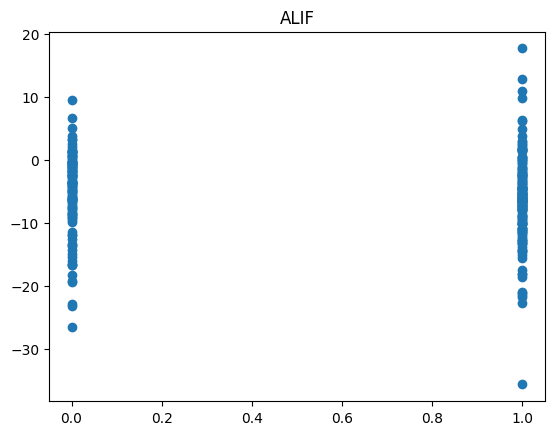

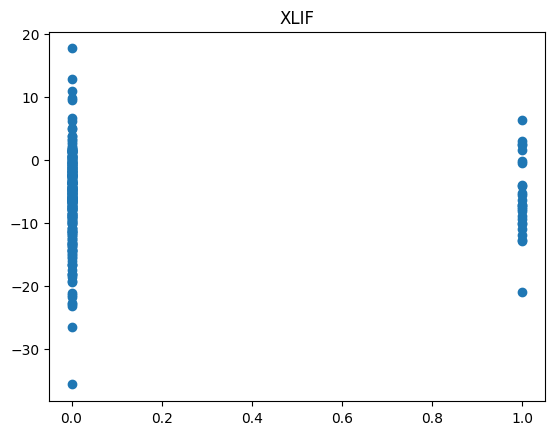

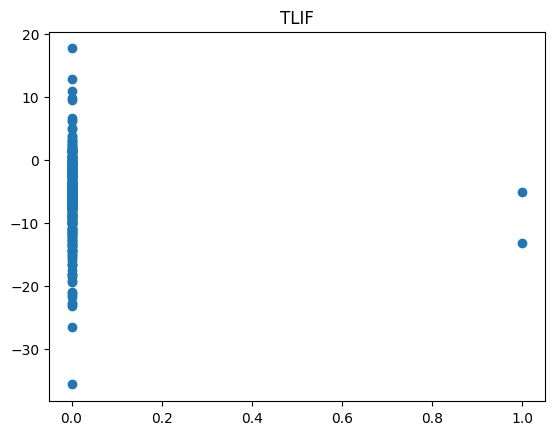

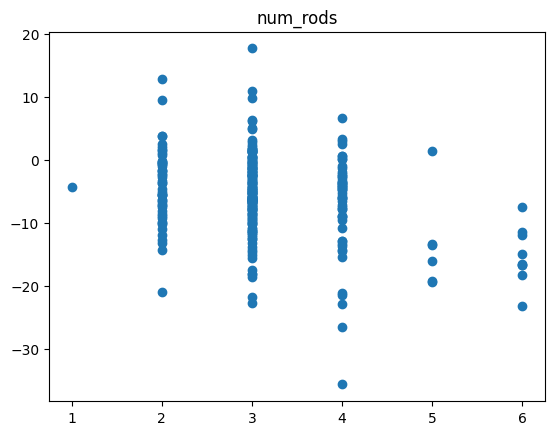

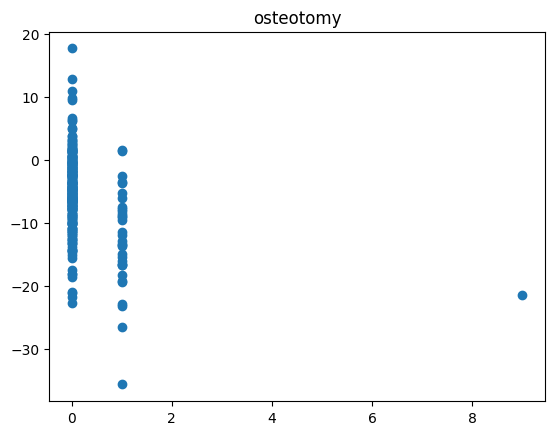

In [18]:
for i in features:
    plt.scatter(df[i], df["L1PA_change"])
    plt.title(i)
    plt.show()

In [219]:

L1PA_cv_params, L1PA_cv_r2, L1PA_tuned_rf, L1PA_cv_ypred, L1PA_cv_testr2, L1PA_cv_rmse = \
    randomized_search_cv(L1PA_rf_pipeline, X_train, y_train, X_test, y_test, param_distributions)

print("--Randomized search results--")
print(f"Best parameters: {L1PA_cv_params}")
print(f"Best CV R2: {L1PA_cv_r2:.3f}")
print(f"Test R2: {L1PA_cv_testr2:.3f}")
print(f"Test RMSE: {L1PA_cv_rmse:.3f}")

--Randomized search results--
Best parameters: {'regressor__n_estimators': 300, 'regressor__min_samples_split': 10, 'regressor__min_samples_leaf': 2, 'regressor__max_features': 'sqrt', 'regressor__max_depth': 15}
Best CV R2: 0.445
Test R2: 0.368
Test RMSE: 4.088


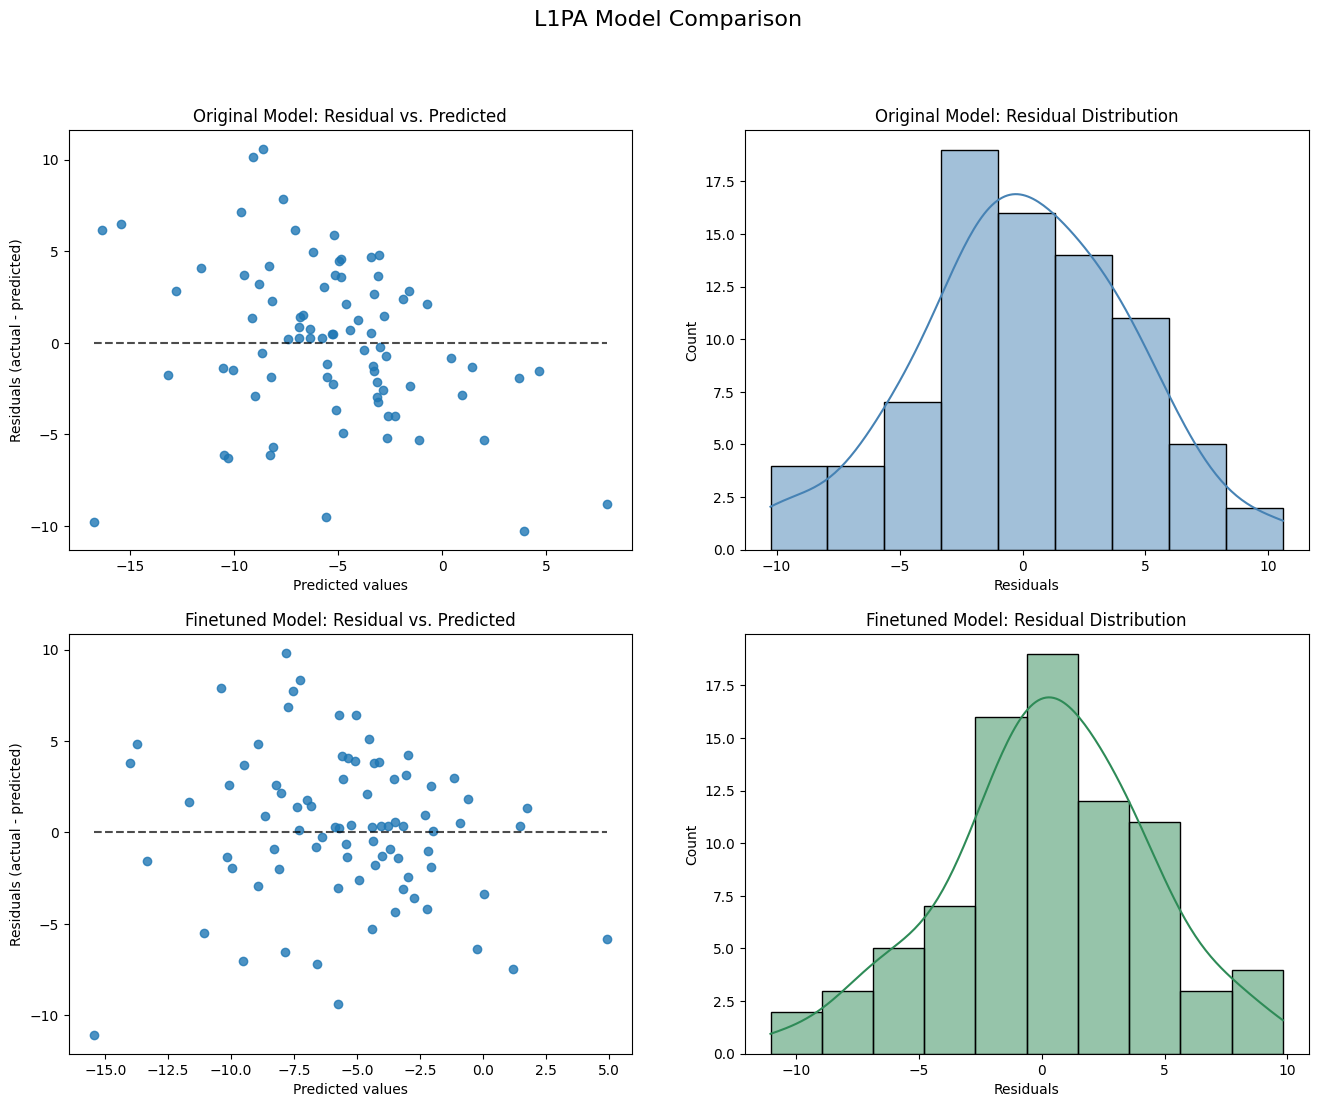

In [ ]:
#Visualization of residuals

fig, ax = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle("L1PA Model Comparison", fontsize=16)

# Plot 1: Residual vs. Predicted (original model)
PredictionErrorDisplay.from_predictions(
    y_true=y_test, y_pred=L1PA_ypred, kind="residual_vs_predicted", 
    ax=ax[0, 0])
ax[0, 0].set_title("Original Model: Residual vs. Predicted")

# Plot 2:  Residual histogram (original model)
L1PA_residuals = y_test - L1PA_ypred
sns.histplot(x=L1PA_residuals, kde=True, ax=ax[0, 1], color='steelblue')
ax[0, 1].set_title("Original Model: Residual Distribution")
ax[0, 1].set_xlabel("Residuals")

# Plot 3: Residual vs. Predicted (finetuned model)
PredictionErrorDisplay.from_predictions(
    y_true=y_test, y_pred=L1PA_cv_ypred, kind="residual_vs_predicted", 
    ax=ax[1, 0]
)
ax[1, 0].set_title("Finetuned Model: Residual vs. Predicted")

# Plot 4: Residual Histogram (finetuned model)
L1PA_cv_residuals = y_test - L1PA_cv_ypred
sns.histplot(x=L1PA_cv_residuals, kde=True, ax=ax[1, 1], color='seagreen')
ax[1, 1].set_title("Finetuned Model: Residual Distribution")
ax[1, 1].set_xlabel("Residuals")

plt.show()

In [221]:
#2. xgboost 

L1PA_xgb_pipeline, L1PA_xgb_r2, L1PA_xgb_rmse, L1PA_xgb_ypred\
      = build_xgboost_model(df,features, cat_features, num_features, X_train, X_test, y_train, y_test)

print("-- XGBoost Model for L1PA change --")

print(f"R² score: {L1PA_xgb_r2:.3f}")
print(f"RMSE: {L1PA_xgb_rmse:.3f}")

-- XGBoost Model for L1PA change --
R² score: 0.165
RMSE: 4.698


In [226]:
#3 ridge regression - might be good for overfitting and correlated features
L1PA_ridge_pipeline, L1PA_ridge_r2, L1PA_ridge_rmse, L1PA_ridge_ypred\
      = build_ridge_model(df,features, cat_features, num_features,X_train, X_test,y_train, y_test)

print("-- Ridge Model for L1PA change --")

print(f"R² score: {L1PA_ridge_r2:.3f}")
print(f"RMSE: {L1PA_ridge_rmse:.3f}")

-- Ridge Model for L1PA change --
R² score: 0.302
RMSE: 4.295


In [227]:
L1PA_ridge_parameters, L1PA_ridge_cv_R2, L1PA_tuned_ridge, L1PA_tuned_ypred, L1PA_ridge_testR2, L1PA_ridge_rmse  = \
    randomized_search_cv(L1PA_ridge_pipeline,X_train,y_train,X_test,y_test, ridge_param_distributions)

print("--Randomized search results--")
print(f"Best parameters: {L1PA_ridge_parameters}")
print(f"Best CV R2: {L1PA_ridge_cv_R2:.3f}")
print(f"Test R2: {L1PA_ridge_testR2:.3f}")
print(f"Test RMSE: {L1PA_ridge_rmse:.3f}")

/Users/jennkim/Library/Caches/pypoetry/virtualenvs/capstone-hbAn-vE8-py3.12/lib/python3.12/site-packages/sklearn/model_selection/_search.py:324: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


--Randomized search results--
Best parameters: {'regressor__alpha': 15}
Best CV R2: 0.485
Test R2: 0.322
Test RMSE: 4.234


### 3. Export Model

In [ ]:
from pathlib import Path
import joblib, sklearn

ARTIFACT_DIR = Path("../artifacts")
ARTIFACT_DIR.mkdir(parents=True, exist_ok=True)

bundle_L4S1 = {
    "pipe": L4S1_ridge_pipeline,
    "features": features,
    "target":"L4S1_change",
    "sklearn_version": sklearn.__version__,
    "model_name": "L4S1_ridge_reg",
}

out_path = ARTIFACT_DIR / "L4S1_model.joblib"
joblib.dump(bundle_L4S1, out_path)
print("Saved:", out_path)

bundle_LL = {
    "pipe": LL_ridge_pipeline,
    "features": features,
    "target": "LL_change",
    "sklearn_version": sklearn.__version__,
    "model_name": "LL_ridge_reg",
}

out_path = ARTIFACT_DIR / "LL_model.joblib"
joblib.dump(bundle_LL, out_path)
print("Saved:", out_path)

bundle_T4PA = {
    "pipe": T4PA_ridge_pipeline,
    "features": features,
    "target": "T4PA_change",
    "sklearn_version": sklearn.__version__,
    "model_name": "T4PA_ridge_reg",
}

out_path = ARTIFACT_DIR / "T4PA_model.joblib"
joblib.dump(bundle_T4PA, out_path)
print("Saved:", out_path)

bundle_L1PA = {
    "pipe": L1PA_rf_pipeline,
    "features": features,
    "target": "L1PA_change",
    "sklearn_version": sklearn.__version__,
    "model_name": "L1PA_rf_reg",
}

out_path = ARTIFACT_DIR / "L1PA_model.joblib"
joblib.dump(bundle_L1PA, out_path)
print("Saved:", out_path)